In [1]:

import keras
import tensorflow as tf
from tensorflow.python.ops import array_ops
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.optimizers import RMSprop
from keras import backend as K
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

Using TensorFlow backend.


In [2]:
import datetime
from matplotlib.image import imread

In [3]:
%widescreen

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8170694551530269892
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8538659246173318512
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4972224487112304130
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6508745360705530784
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10896169370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12239743099213784672
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
]


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
input_image_size = (480,640,3)

base_model = VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(input_image_size), 
)

for layer in base_model.layers:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(512, activation="relu")(x)
predictions = Dense(3, activation='softmax')(x)

# creating the final model 
model = Model(input = base_model.input, output = predictions)

# compile the model 
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = Adam(), #SGD(lr=0.0001, momentum=0.9), 
    metrics=["accuracy"]
)
    


W0207 16:09:58.181301 140243401434944 deprecation_wrapper.py:119] From /home/dougo/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

/home/dougo/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 160, 128)     0   

In [8]:
# model.load_weights("model_weights_checkpoint_2020-02-05T13_43_24.296156.h5")

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.25,
    zoom_range=0.25,
    rotation_range=0.2,
)
train_generator = train_datagen.flow_from_directory(
    directory=r"/ssd1/lick_detection_model/three_class_model/train/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3129 images belonging to 3 classes.


In [10]:
nonshuffled_train_generator = train_datagen.flow_from_directory(
    directory=r"/ssd1/lick_detection_model/three_class_model/train/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 3129 images belonging to 3 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_generator = valid_datagen.flow_from_directory(
    directory=r"/ssd1/lick_detection_model/three_class_model/validate/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 392 images belonging to 3 classes.


In [12]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)
test_generator = valid_datagen.flow_from_directory(
    directory=r"/ssd1/lick_detection_model/three_class_model/test/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=False,
)

Found 391 images belonging to 3 classes.


In [13]:
# setup callbacks
earlystop = EarlyStopping(patience=20)

datestamp = str(datetime.datetime.now()).replace(':','_').replace(' ','T')

checkpoint_name = "/ssd1/lick_detection_model/three_class_model/model_weights_checkpoint_{}.h5".format(datestamp)
checkpoint = ModelCheckpoint(
                            checkpoint_name, 
                            monitor='val_accuracy', 
                            verbose=0, 
                            save_best_only=True, 
                            save_weights_only=True,
                            mode='auto')

callbacks = [earlystop, checkpoint]

In [14]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks = callbacks,
)

W0207 16:10:45.967440 140243401434944 deprecation_wrapper.py:119] From /home/dougo/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/50
391/391 [==============================] - 214s 547ms/step - loss: 3.1419 - accuracy: 0.6331 - val_loss: 0.5728 - val_accuracy: 0.6046
Epoch 2/50
391/391 [==============================] - 212s 542ms/step - loss: 0.6539 - accuracy: 0.7603 - val_loss: 0.1025 - val_accuracy: 0.8393
Epoch 3/50
391/391 [==============================] - 220s 562ms/step - loss: 0.4822 - accuracy: 0.8145 - val_loss: 0.1174 - val_accuracy: 0.8724
Epoch 4/50
391/391 [==============================] - 208s 533ms/step - loss: 0.4031 - accuracy: 0.8372 - val_loss: 0.4741 - val_accuracy: 0.7372
Epoch 5/50
391/391 [==============================] - 210s 538ms/step - loss: 0.3834 - accuracy: 0.8523 - val_loss: 0.2342 - val_accuracy: 0.8622
Epoch 6/50
391/391 [==============================] - 212s 543ms/step - loss: 0.4053 - accuracy: 0.8404 - val_loss: 0.7378 - val_accuracy: 0.8929
Epoch 7/50
229/391 [================>.............] - ETA: 1:24 - loss: 0.4256 - accuracy: 0.8290

E0207 16:34:10.077962 140243401434944 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/dougo/.conda/envs/keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-3a4aaf44572f>", line 9, in <module>
    callbacks = callbacks,
  File "/home/dougo/.conda/envs/keras/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/dougo/.conda/envs/keras/lib/python3.6/site-packages/keras/engine/training.py", line 1732, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/dougo/.conda/envs/keras/lib/python3.6/site-packages/keras/engine/training_generator.py", line 220, in fit_generator
    reset_metrics=False)
  File "/home/dougo/.conda/envs/keras/lib/python3.6/site-packages/keras/engine/training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "/home/dougo/.conda/envs/keras/lib/python3.6/site-packages/tensorflow/pyt

KeyboardInterrupt: 

In [19]:
history


import keras
import tensorflow as tf
from tensorflow.python.ops import array_ops
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.optimizers import RMSprop
from keras import backend as K
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
import datetime
from matplotlib.image import imread
%widescreen
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_image_size = (480,640,3)

base_model = VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(input_image_size), 
)

for layer in base_model.layers:
    layer.trainable 

NameError: name 'history' is not defined

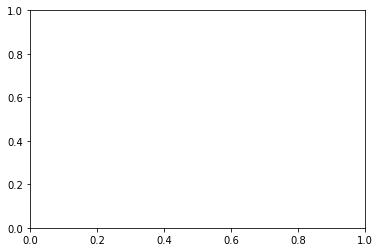

In [20]:
fig,ax=plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

In [16]:
def plot_example(predictions,generator,index,ax,fontsize=10):
    reverse_class_lookup = {v:k for k,v in generator.class_indices.items()}
    
    filename = os.path.join(generator.directory,generator.filenames[index])
    actual_class_index = generator.classes[index]
    actual_class_name = reverse_class_lookup[actual_class_index]
    
    predicted_class = predictions[index].argmax()
    predicted_class_name = reverse_class_lookup[predicted_class]
    predicted_class_probability = predictions[index][predicted_class]
    
    image = imread(filename)
    ax.imshow(image)
    
    ax.set_title(
        '{}\nactual class = {}\npredicted class = {}\nprobability = {}'.format(
            generator.filenames[index], 
            actual_class_name, 
            predicted_class_name,
            predicted_class_probability,
        ),
        fontsize=fontsize,
    )
    ax.set_xticks([])
    ax.set_yticks([])

    if predicted_class_name == actual_class_name:
        color='green'
    else:
        color='red'
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5)
        
    return ax

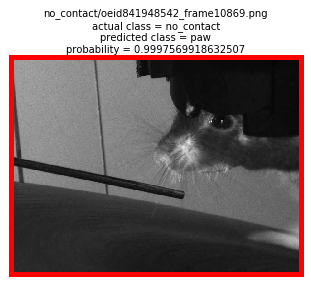

In [21]:
predictions = model.predict_generator(valid_generator)
fig,ax=plt.subplots()
plot_example(predictions,valid_generator,index=0,ax=ax)

In [22]:
def visualize_predictions(model, generator):
    generator.reset()
    print('making predictions')
    predictions = model.predict_generator(generator)
    print('done with predictions')
    
    indices = np.arange(len(generator.filenames))
    
    fig,axes=plt.subplots(int(np.ceil(len(generator.filenames)/8)),8,figsize=(25,2.5*np.ceil(len(generator.filenames)/8)))
    for ii,index in enumerate(indices):
        ax = axes.flatten()[ii]
        plot_example(predictions,generator,index=index,ax=ax,fontsize=8)

    fig.tight_layout()
    
    return fig,axes

In [26]:
model_evaluation = model.evaluate_generator(test_generator)

In [ ]:
fig,axes = visualize_predictions(model,test_generator)
plt.subplots_adjust(top=0.98)
fig.suptitle('accuracy on test set = {:.3f}'.format(model_evaluation[1]))
fig.savefig('/ssd1/model_vis.png',dpi=100)

making predictions
done with predictions


In [25]:
fig


Text(0.5, 0.98, '[0.004277786239981651, 0.8885449171066284]')

<Figure size 432x288 with 0 Axes>